# Excitation Backprop Tutorial: MNIST Classification

Sam Greydanus. March 2018. MIT License.

In this notebook, we'll use excitation backprop (EB) to explore a simple linear MNIST model.

For an in-depth explanation of EB, refer to [this paper](https://arxiv.org/abs/1608.00507). The [original code](https://github.com/jimmie33/Caffe-ExcitationBP) is in Caffe.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function, Variable
from torchvision import datasets, models, transforms, utils

import numpy as np
import matplotlib.pyplot as plt

import os, sys, copy ; sys.path.append('..')
import excitation_bp as eb

reseed = lambda: np.random.seed(seed=1) ; ms = torch.manual_seed(1) # for reproducibility
reseed()

### 1) Make a dataloader for the MNIST dataset

We'll just wrap the built-in Torch utility. Add lots of noise.

In [2]:
# data loader
class Dataloader():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.modes = modes = ['train', 'test']
        trans = transforms.Compose([transforms.ToTensor(),]) # transforms.Normalize((0.1307,), (0.3081,))
        dsets = {k: datasets.MNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
        self.loaders = {k: torch.utils.data.DataLoader(dsets[k], batch_size=batch_size, shuffle=True) for k in modes}

    def next(self, mode='train',sigma=0.8):
        X, y = next(iter(self.loaders[mode]))
        return Variable(X + sigma*torch.rand(X.shape)).view(self.batch_size, -1), Variable(y)

def accuracy(model, dataloader, mode='test'):
    correct = 0
    nbatches = int(10000/dataloader.batch_size)
    for _ in range(nbatches):
        X, y = dataloader.next(mode)
        pred = model(X).data.max(1)[1]
        correct += pred.eq(y.data).sum()
    return 100*correct/(dataloader.batch_size*nbatches)

### 2) Define the model

In [3]:
class MnistClassifier(nn.Module):
    def __init__(self, hdim=200):
        super(MnistClassifier, self).__init__()
        self.linear1 = nn.Linear(28**2, hdim)
        self.linear2 = nn.Linear(hdim, hdim)
        self.linear3 = nn.Linear(hdim, 10)

    def forward(self, x):
        activations = []
        h1 = F.relu(self.linear1(x))
        h2 = F.relu(self.linear2(h1))
        h3 = self.linear3(h2)
        return h3

### 3) Train the model

In [4]:
model = MnistClassifier(hdim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
dataloader = Dataloader(256)

global_step = 0 ; total_steps = 2000 ; test_every = int(total_steps/20)
running_loss = None ; acc_msg = '...'
loss_hist, acc_hist = [], []

# generic train loop
for global_step in range(global_step, total_steps+global_step+1):

    # ======== DISCRIMINATOR STEP ======== #
    X, y = dataloader.next()
    logits = model(X)
    y_hat = F.log_softmax(logits, dim=-1)
    loss = F.nll_loss(y_hat, y)
    loss.backward() ; optimizer.step() ; optimizer.zero_grad()

    np_loss = loss.data.numpy()[0]
    running_loss = np_loss if running_loss is None else .99*running_loss + (1-.99)*np_loss
    loss_hist.append(running_loss)

    # ======== DISPLAY PROGRESS ======== #
    print('\tstep {}/{} | {} | loss: {:.4f}'.format(global_step, total_steps, acc_msg, running_loss), end="\r")
    if global_step % test_every == 0:
        a = accuracy(model, dataloader, mode='test')
        acc_hist.append(a) ; acc_msg = 'accuracy: {:.4f}%'.format(a)

### 4) Extend Torch's autograd functions to support Excitation Backprop (EB)

Refer to **Alg. 1** in the original paper. The relevant (general) equation is:

$$ P_n = A_n \odot W^+ \left(\frac{P_{n-1}}{W^{+T}A_n}\right) $$
    
We only need to do this to the Linear function for the model we just trained. Other functions that need this extension include:
 * any convolutional function
 * average pooling
 * any pointwise function that has a min value less than 0
     * these must have their min values subtracted from their outputs

In [5]:
eb.use_eb(True)

using excitation backprop autograd mode:
	->replacing torch.nn.functional.linear with eb_linear...
	->replacing torch.nn.functional.conv{1,2,3}d with eb_conv{1,2,3}d...
	->replacing torch.nn.functional.avg_pool2d with eb_avg_pool2d...


### 5) Excitation Backprop (EB)

In [8]:
class_labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
X, y = dataloader.next(mode='test')
inputs = inputs = X[0:1,:]

# compute excitation backprop for correct label
one_id = 1
true_id = y.data[0]
prob_outputs_one = Variable(torch.zeros(1,10)) ; prob_outputs_one.data[:,one_id] += 1
prob_outputs_true = Variable(torch.zeros(1,10)) ; prob_outputs_true.data[:,true_id] += 1

prob_inputs_one = eb.excitation_backprop(model, inputs, prob_outputs_one, contrastive=False)
prob_inputs_true = eb.excitation_backprop(model, inputs, prob_outputs_true, contrastive=False)

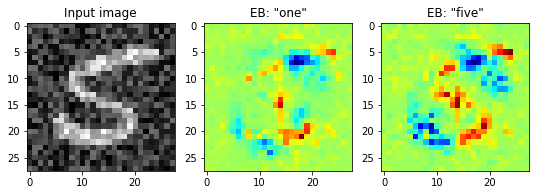

In [14]:
beta = 0.5 # adjust the 'peakiness' of data
one_img = prob_inputs_one.view(28,28).data.numpy()
true_img = prob_inputs_true.view(28,28).data.numpy()

# visualize
s = 3
f = plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Input image')
plt.imshow(inputs.data.view(28,28).numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.title('EB: "{}"'.format(class_labels[one_id][:15]))
plt.imshow(one_img, cmap='jet')

plt.subplot(1,3,3)
plt.title('EB: "{}"'.format(class_labels[true_id][:15]))
plt.imshow(true_img, cmap='jet')
plt.show() ; f.savefig('figures/mnist-eb.png', bbox_inches='tight')

### 6) Contrastive Excitation Backprop (c-EB)

In [15]:
prob_inputs_one = eb.excitation_backprop(model, inputs, prob_outputs_one, contrastive=True)
prob_inputs_true = eb.excitation_backprop(model, inputs, prob_outputs_true, contrastive=True)

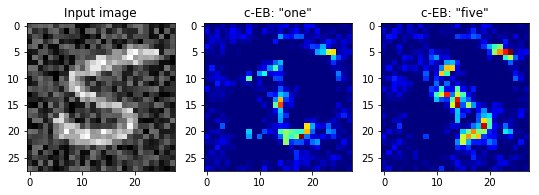

In [16]:
beta = 0.5 # adjust the 'peakiness' of data
one_img = prob_inputs_one.clamp(min=0).view(28,28).data.numpy()
true_img = prob_inputs_true.clamp(min=0).view(28,28).data.numpy()

# visualize
s = 3
plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Input image')
plt.imshow(inputs.data.view(28,28).numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.title('c-EB: "{}"'.format(class_labels[one_id][:15]))
plt.imshow(one_img, cmap='jet')

plt.subplot(1,3,3)
plt.title('c-EB: "{}"'.format(class_labels[true_id][:15]))
plt.imshow(true_img, cmap='jet')
plt.show() ; f.savefig('figures/mnist-ceb.png', bbox_inches='tight')